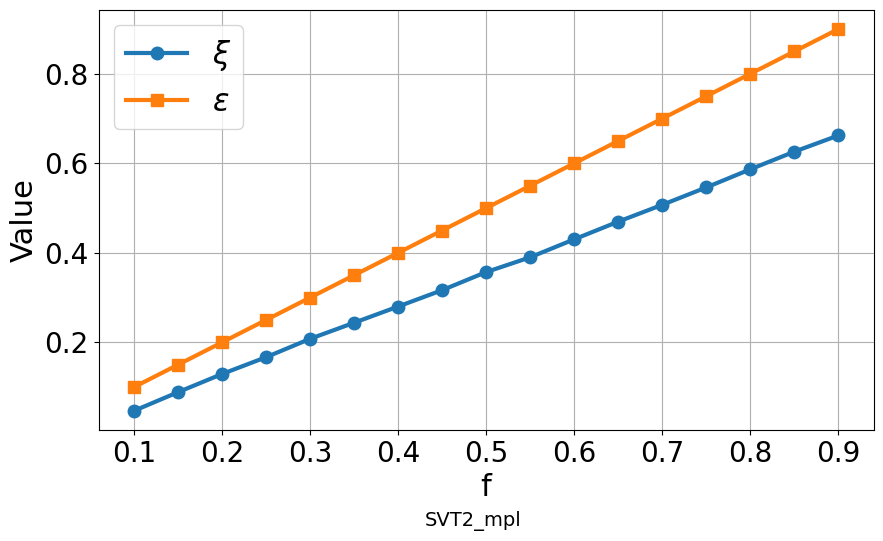

In [4]:
import numpy as np
import scipy.stats as stats
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.stats import laplace, norm

# These functions are used to calculate the true privacy parameter


def hyp_distance_max(scal_par):
    m_1 = 2
    m_2 = 1
    out = scal_par * (max(m_1, m_2) - min(m_1, m_2)) + np.log(2 - np.exp(
        -scal_par * max(m_1, m_2))) - np.log(2 -
                                             np.exp(-scal_par * min(m_1, m_2)))
    return out


def NoisyMax(queries, epsilon, sensitivity):
    noisyQueries = np.array(queries) + laplace.rvs(
        scale=2 * sensitivity / epsilon, size=len(queries))
    return np.where(noisyQueries == max(noisyQueries))


def inverse(f, lower=-100, upper=100):

    def func(y):
        return root_scalar(lambda x: f(x) - y, bracket=[lower, upper]).root

    return func
 

hyp_inverse = inverse(hyp_distance_max, 0, 10)


class SparseVectorTechnique2():
    """
    Alg. 2 from:
        M. Lyu, D. Su, and N. Li. 2017.
        Understanding the Sparse Vector Technique for Differential Privacy.
        Proceedings of the VLDB Endowment.
    """

    def __init__(self, eps: float = 0.1, c: int = 2, t: float = 1.0):
        self.eps1 = eps / 2.0
        self.eps2 = eps - self.eps1
        self.c = c  # maximum number of queries answered with 1
        self.t = t

    def m(self, a, n_samples: int = 1):
        """
        Args:
            a: 1d array of query results (sensitivity 1)

        Returns:
            ndarray of shape (n_samples, a.shape[0]) with entries
                1 = TRUE;
                0 = FALSE;
                -1 = ABORTED;
        """

        # columns: queries
        # rows: samples
        x = np.atleast_2d(a)
        n_queries = a.shape[0]

        rho = np.random.laplace(scale=self.c / self.eps1, size=(n_samples,))
        nu = np.random.laplace(scale=2*self.c / self.eps2, size=(n_samples, n_queries))

        m = nu + x  # broadcasts x vertically

        count = np.zeros(n_samples)
        aborted = np.full(n_samples, False)
        res = np.empty(shape=m.shape, dtype=int)
        for col_idx in range(0, n_queries):
            cmp = m[:, col_idx] >= (rho + self.t)
            res[:, col_idx] = cmp.astype(int)
            res[aborted, col_idx] = -1
            count = count + cmp

            # update rho whenever we answer TRUE
            new_rho = np.random.laplace(scale=self.c / self.eps1, size=(n_samples,))
            rho[cmp] = new_rho[cmp]

            aborted = np.logical_or(aborted, count == self.c)
        return res


# print(data_bases.shape[1] // 2 - 1)
v1 = np.array([0, 0, 0, 1, 1, 1])
v2 = np.array([1, 1, 1, 1, 1, 1])

data_bases = np.column_stack((v1, v2))

for i in range(3):
    v2[i + 3] = 0
    data_bases = np.column_stack((data_bases, v1, v2))

for i in range(2, 5):
    v2[7 - i] = 2
    data_bases = np.column_stack((data_bases, v1, v2))

v1 = np.array([1, 1, 1, 1, 1, 1])
v2 = np.array([0, 0, 0, 2, 2, 2])

data_bases = np.column_stack((data_bases, v1, v2))

for i in range(2, 4):
    v2[4 - i] = 1
    data_bases = np.column_stack((data_bases, v1, v2))


def MPL(data_set, eps, sens, n, N, alpha, delta,privacy_mechanism):
    epsilon_max = -1
    t_max = np.array([])
    x1_max = np.array([])
    x2_max = np.array([])

    for i in range(data_set.shape[1] // 2):
       
        # Sample output data and create density vector for the first query
        qu_1 = data_set[:, (2 * i)]

        result_1 = privacy_mechanism.m(qu_1, n)
       

        # Create an array to store the frequency of each unique vector
        unique_data, counts = np.unique(result_1, axis=0, return_counts=True)

        
        dens_1 = np.zeros(unique_data.shape)

        
        dens_1 = counts / n
        

        # Sample output data and create density vector for the neighboring query
        qu_2 = data_set[:, 2 * i + 1]
        # print(qu_2)
        result_2 = privacy_mechanism.m(qu_2, n)
       
        # Create an array to store the frequency of each unique vector
        unique_data, counts = np.unique(result_2, axis=0, return_counts=True)
        dens_2 = np.zeros(unique_data.shape)

        # 使用 NumPy 向量化操作计算 dens_2
        dens_2 = counts / n
        
        # Compute loss function with floor and determine maximum loss
        loss_hat = np.abs(
            np.log(np.maximum(delta, dens_1)) -
            np.log(np.maximum(delta, dens_2)))

        epsilon_hat = max(loss_hat)
        t_hat = np.argmax(loss_hat)

        # Record data bases and location associated with the current maximum loss
        if epsilon_hat > epsilon_max:
            epsilon_max = epsilon_hat
            t_max = t_hat
            x1_max = qu_1
            x2_max = qu_2

    # Recompute Maximum Loss and Statistic on larger sample sizes
    result_3 = privacy_mechanism.m(x1_max, N)
    
    # Create an array to store the frequency of each unique vector
    unique_data, counts = np.unique(result_3, axis=0, return_counts=True)

    
    dens_3 = np.zeros(unique_data.shape)

    
    dens_3 = (counts / N)
    f_star_1 = max(dens_3[t_max], delta)

    # Recompute Maximum Loss and Statistic on larger sample sizes
    result_4 = privacy_mechanism.m(x2_max, N)
    
    # Create an array to store the frequency of each unique vector
    unique_data, counts = np.unique(result_4, axis=0, return_counts=True)

   
    dens_4 = np.zeros(unique_data.shape)

    
    dens_4 = (counts / N)
    f_star_2 = max(dens_4[t_max], delta)

    sigma_hat = (1 / f_star_1 + 1 / f_star_2) - 2
    loss_star = np.abs(np.log(f_star_1) - np.log(f_star_2))

    LB = loss_star + (stats.norm.ppf(alpha) * np.sqrt(sigma_hat)) / np.sqrt(N)

    return LB



sens = 1
n = 100000
N = 500000
alpha = 0.05
delta = 0.0001

tune = 0.15
C = np.array([0, 2])
glob = C[1] - C[0]
C_discr = np.linspace(C[0], C[1], num=21)

reps = 50

f_values = np.arange(0.1, 0.95, 0.05)
epslion_star = np.zeros_like(f_values)
xi_hat = np.zeros_like(f_values)
epsilon = np.zeros_like(f_values)

for i, f in enumerate(f_values):
    epslion_star[i] = f
    privacy_mechanism = SparseVectorTechnique2(eps=f, c=1, t=-1)
    A = Parallel(n_jobs=7)(delayed(MPL)(data_bases, f, sens, n, N, alpha, delta,privacy_mechanism)for _ in range(reps))
    final_array = np.array(A)
    xi_hat[i] = sum(final_array) / len(final_array)

plt.figure(figsize=(10, 6))
plt.subplots_adjust(bottom=0.18)

# print the first line
plt.plot(f_values, xi_hat, marker='o', markersize=9,linewidth=3,label=r'$\xi$')

# print the second line
plt.plot(f_values, epslion_star, marker='s',markersize=9, linewidth=3,label=r'$\epsilon$')




plt.xlabel('f', fontsize=22)
plt.ylabel('Value', fontsize=22)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  
plt.legend(fontsize=22)
plt.grid(True)

# gcf: Get Current Figure
fig=plt.gcf()
fig.text(0.5, 0.02, 'SVT2_mpl', ha='center', fontsize=14)
fig.savefig('SVT2.svg',format='svg')